4-4. 실습 (1) 데이터 다듬기



In [1]:
import os, re 
import numpy as np
import tensorflow as tf

# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = os.getenv('HOME') + '/aiffel/lyricist/data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


In [2]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


텍스트 분류 모델에서 많이 보신 것처럼 텍스트 생성 모델에도 단어 사전을 만들게 됩니다. 그렇다면 문장을 일정한 기준으로 쪼개야겠죠? 그 과정을 토큰화(Tokenize) 라고 합니다.

가장 심플한 방법은 띄어쓰기를 기준으로 나누는 방법이고, 우리도 그 방법을 사용할 겁니다. 하지만 약간의 문제가 있을 수 있죠. 몇 가지 문제 케이스를 살펴보죠.

Hi, my name is John. *("Hi," "my", ..., "john." 으로 분리됨) - 문장부호
First, open the first chapter. *(First와 first를 다른 단어로 인식) - 대소문자
He is a ten-year-old boy. *(ten-year-old를 한 단어로 인식) - 특수문자
"1." 을 막기 위해 문장 부호 양쪽에 공백을 추가 할 거고요, "2." 를 막기 위해 모든 문자들을 소문자로 변환 할 겁니다. "3."을 막기 위해 특수문자들은 모두 제거 하도록 하죠!

이런 전처리를 위해 정규표현식(Regex)을 이용한 필터링이 유용하게 사용됩니다.



In [3]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


자연어처리 분야에서 모델의 입력이 되는 문장을 소스 문장(Source Sentence) , 정답 역할을 하게 될 모델의 출력 문장을 타겟 문장(Target Sentence) 라고 관례적으로 부릅니다. 각각 X_train, y_train 에 해당한다고 할 수 있겠죠?

그렇다면 우리는 위에서 만든 정제 함수를 통해 만든 데이터셋에서 토큰화를 진행한 후 끝 단어 <end>를 없애면 소스 문장, 첫 단어 <start>를 없애면 타겟 문장이 되겠죠? 이 정제 함수를 활용해서 아래와 같이 정제 데이터를 구축합니다!

In [4]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

이제 데이터는 완벽하게 준비가 된 것 같네요!

자, 새로운 언어를 배우는 상상을 해봅시다. 영어를 전혀 모르던 그 때로 돌아가서, 다시 영어를 배우려면 어떻게 해야 할까요? 영한사전 을 허리춤에 끼고 문장 속 단어를 하나하나 찾아가며 한국어 해석 을 적겠죠? 이 아이디어는 인공지능에게도 똑같이 적용됩니다. 배우고자 하는 언어 를 모국어로 표현 을 해야 공부를 할 수 있어요.

인공지능의 모국어라면 단연 숫자 겠죠. 우리는 가르칠 언어(데이터)를 숫자로 변환해서 인공지능에게 줄 겁니다. 이에 필요한 것은 사전 ! 굳이 명명하자면... 데숫사전...?

텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공하는데, 우리도 그 모듈을 십분 활용할 겁니다! 아래에서 활용하게 될 tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 데이터를 숫자로 변환까지 한 방에 해줍니다. 이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다. 우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리되는 것입니다.

In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f04f9629390>


In [6]:
print(tensor[:3, :10]) # 생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 봅시다.

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


텐서 데이터는 모두 정수로 이루어져 있습니다. 이 숫자는 다름 아니라, tokenizer에 구축된 단어 사전의 인덱스입니다. 단어 사전이 어떻게 구축되었는지 아래와 같이 확인해 봅시다.

In [7]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break # 인덱스가 10 이상이면 break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


어떻습니까? 2번 인덱스가 바로 <start>였습니다. 왜 모든 행이 2로 시작하는지 이해할 수 있겠습니다.

이제 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 하겠습니다. 이 과정도 텐서플로우 가 제공하는 모듈을 사용할 것이니, 어떻게 사용하는지만 눈여겨 봐둡시다.

텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것입니다. 사전에는 없지만 0은 바로 패딩 문자 <pad>가 될 것입니다.

In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았습니다. 예상대로 소스는 2(<start>)에서 시작해서 3(<end>)으로 끝난 후 0(<pad>)로 채워져 있습니다. 하지만 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태를 가지고 있습니다.

마지막으로 우리는 데이터셋 객체를 생성할 것입니다. 그동안 우리는 model.fit(x_train, y_train, ...) 형태로 Numpy Array 데이터셋을 생성하여 model에 제공하는 형태의 학습을 많이 진행해 왔습니다. 그러나 텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해 tf.data.Dataset객체를 생성하는 방법을 흔히 사용합니다. tf.data.Dataset객체는 텐서플로우에서 사용할 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공하므로 꼭 사용법을 알아 두시기를 권합니다. 우리는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것입니다.

In [9]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 20), (256, 20)), types: (tf.int32, tf.int32)>

이번 스텝에서 데이터셋을 생성하기 위해 거쳐 온 과정을 잘 기억해 두시길 바랍니다.

- 정규표현식을 이용한 corpus 생성
- tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환
- tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

dataset을 얻음으로써 데이터 다듬기 과정은 끝났습니다. tf.data.Dataset에서 제공하는 shuffle(), batch() 등 다양한 데이터셋 관련 기능을 손쉽게 이용할 수 있게 되었군요.

이 모든 일련의 과정을 텐서플로우에서의 데이터 전처리 라 칭합니다!

4-5. 실습 (2) 인공지능 학습시키기



In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

텍스트 분류 모델을 다루어 보셨다면 Embedding 레이어의 역할에 대해서는 낯설지 않을 것입니다. 우리 입력 텐서에는 단어 사전의 인덱스가 들어 있습니다. Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 줍니다. 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됩니다.

위 코드에서 embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기입니다. 만약 그 크기가 2라면 예를 들어

- 차갑다: [0.0, 1.0]
- 뜨겁다: [1.0, 0.0]
- 미지근하다: [0.5, 0.5]

정도의 구분이 가능하겠군요. 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 그만큼 충분한 데이터가 주어지지 않으면 오히려 혼란만을 야기할 수 있습니다. 이번 실습에서는 256이 적당해 보이네요.

LSTM 레이어의 hidden state 의 차원수인 hidden_size 도 같은 맥락입니다. hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인가? 로 이해해도 크게 엇나가지 않습니다. 그 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 역시 충분한 데이터가 주어지면 올바른 결정을 내리겠지만 그렇지 않으면 배가 산으로 갈 뿐 입니다. 이번 실습에는 1024가 적당해보이는군요.

우리의 model은 아직 제대로 build되지 않았습니다. model.compile()을 호출한 적도 없고, 아직 model의 입력 텐서가 무엇인지 제대로 지정해 주지도 않았기 때문입니다.
그런 경우 아래와 같이 model에 데이터를 아주 조금 태워 보는 것도 방법입니다. model의 input shape가 결정되면서 model.build()가 자동으로 호출됩니다.

In [11]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ 5.10321224e-05, -1.21536315e-04,  1.86351259e-04, ...,
          2.54257111e-06,  2.56849424e-04,  8.17465916e-05],
        [-1.52505585e-04,  1.36655770e-04,  3.52020434e-04, ...,
         -2.23279421e-04,  6.16769306e-04,  2.22252274e-04],
        [-8.72967430e-05,  3.35696619e-04,  4.74986766e-04, ...,
         -5.45724724e-05,  6.84756786e-04,  1.78641436e-04],
        ...,
        [-1.42985873e-03,  1.33758225e-03,  1.40110380e-03, ...,
          3.52989184e-04,  2.69040640e-04,  1.06144114e-03],
        [-1.50609459e-03,  1.76364090e-03,  2.10960023e-03, ...,
          2.68676988e-04,  2.15465523e-04,  1.60291081e-03],
        [-1.59191224e-03,  2.15453026e-03,  2.75303214e-03, ...,
          1.63100616e-04,  1.66759826e-04,  2.17933673e-03]],

       [[ 5.10321224e-05, -1.21536315e-04,  1.86351259e-04, ...,
          2.54257111e-06,  2.56849424e-04,  8.17465916e-05],
        [-3.53112729e-04,  1.55648682e-04,  4.

모델의 최종 출력 텐서 shape를 유심히 보면 shape=(256, 20, 7001)임을 알 수 있습니다. 7001은 Dense 레이어의 출력 차원수입니다. 7001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문입니다.
256은 이전 스텝에서 지정한 배치 사이즈입니다. dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것입니다.

그렇다면 20은 무엇을 의미할까요? 비밀은 바로 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있습니다. 즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미입니다. 만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것입니다.

그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점입니다. 모델을 만들면서 알려준 적도 없습니다. 그럼 20은 언제 알게된 것일까요? 네, 그렇습니다. 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 20으로 맞춰져 있었던 것입니다.

In [12]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1792256   
_________________________________________________________________
lstm (LSTM)                  multiple                  5246976   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense (Dense)                multiple                  7176025   
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


이제 드디어 model.summary()를 호출할 수 있게 되었습니다. 그런데 호출해 보니 그동안 많이 보았던 것과는 다른 점이 있습니다. 우리가 궁금했던 Output Shape를 정확하게 알려주지 않습니다. 바로 위에서 설명한 이유 때문입니다. 우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.

하지만 모델의 파라미터 사이즈는 측정됩니다. 대략 22million 정도 되는군요. 참고로 서두에 소개했던 GPT-2의 파라미터 사이즈는, 1.5billion입니다. 우리 모델의 100배까지는 안되더라도 수십배가 넘는군요. 놀라지 마세요. GPT-3의 파라미터 사이즈는 GPT-2의 100배니까요.

학습엔 15분 정도 소요됩니다(GPU 환경 기준). 간단한 스트레칭과 커피 한 잔을 만들어 오기에 적당한 시간이죠.
혹시라도 학습에 지나치게 많은 시간이 소요된다면 tf.test.is_gpu_available() 소스를 실행해 텐서플로우가 GPU를 잘 사용하고 있는지 확인하시길 바랍니다!

In [13]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)
model.fit(dataset, epochs=30)

Epoch 1/30
62/93 [===================>..........] - ETA: 11s - loss: 4.8105

KeyboardInterrupt: 

Loss는 모델이 오답을 만들고 있는 정도라고 생각하셔도 좋습니다(그렇다고 Loss가 1일 때 99%를 맞추고 있다는 의미는 아닙니다). 오답률이 감소하고 있으니 학습이 잘 진행되고 있다 고 해석할 수 있죠!

학습이 완료되었다면 이제 모델을 평가해 봅시다.

# 4-6. 실습 (3) 잘 만들어졌는지 평가하기

모델이 작문을 잘하는지 컴퓨터 알고리즘이 평가하는 것은 무리가 있습니다. 만약에 그게 가능했다면 우리가 지금껏 해온 독후감 숙제를 컴퓨터가 채점했겠죠? 따라서 작문 모델을 평가하는 가장 확실한 방법은 작문을 시켜보고 직접 평가하는 겁니다. 아래 generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다.


In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

텍스트를 생성하는 함수 안을 들여다보면 while문이 하나 자리 잡고 있는 것을 볼 수 있습니다. 왜 그럴까요?

학습 단계에서 우리는 이런 while 문이 필요 없었습니다. 소스 문장과 타겟 문장이 있었고, 우리는 소스 문장을 모델에 입력해서 나온 결과를 타겟 문장과 직접 비교하면 그만이었습니다.
그러나 텍스트를 실제로 생성해야 하는 시점에서, 우리에게는 2가지가 없습니다. 하나는 타겟 문장입니다. 또 하나는 무엇이냐 하면, 소스 문장입니다. 생각해 보면 우리는 텍스트 생성 태스크를 위해 테스트 데이터셋을 따로 생성한 적이 없습니다.

generate_text() 함수에서 init_sentence를 인자로 받고는 있습니다. 이렇게 받은 인자를 일단 텐서로 만들고 있습니다. 디폴트로는 <start> 단어 하나만 받는군요.

- while의 첫 번째 루프에서 test_tensor에 <start> 하나만 들어갔다고 합시다. 우리의 모델이 출력으로 7001개의 단어 중 A를 골랐다고 합시다.
- while의 두 번째 루프에서 test_tensor에는 <start> A가 들어갑니다. 그래서 우리의 모델이 그다음 B를 골랐다고 합시다.
- while의 세 번째 루프에서 test_tensor에는 <start> A B가 들어갑니다. 그래서..... (이하 후략)

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> he")

제법 멋진 문장을 생성해냈군요! 위 함수의 init_sentence 를 바꿔가며 이런저런 실험을 해보세요! 단, <start>를 빼먹지는 않도록 합시다.

# 4-7. 프로젝트: 멋진 작사가 만들기

## Step 1. 데이터 다운로드

이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 
~/aiffel/lyricist/data를 생성하셨다면, 
~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.


## Step 2. 데이터 읽어오기

glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. 
glob 를 활용하여 모든 txt 파일을 읽어온 후, 
raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

## Step 3. 데이터 정제

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠? 이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.
그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

## Step 4. 평가 데이터셋 분리

훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

## Step 5. 인공지능 만들기

모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요! (Loss는 아래 제시된 Loss 함수를 그대로 사용!)

그리고 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!



## Step 1. 데이터 다운로드

이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 
~/aiffel/lyricist/data를 생성하셨다면, 
~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

## Step 2. 데이터 읽어오기

In [14]:
import glob
import os
import re

# Step 1. 데이터 다운로드
# 이미 실습(1) 데이터 다듬기에서 Cloud shell에 심볼릭 링크로 
# ~/aiffel/lyricist/data를 생성하셨다면, 
# ~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

# Step 2. 데이터 읽어오기
# glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요. 
# glob 를 활용하여 모든 txt 파일을 읽어온 후, 
# raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'
txt_list = glob.glob(txt_file_path)

raw_corpus = [] # corpus의 뜻은 말뭉치

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # raw 에 읽어온 파일을 잘라서 넣음
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus)) # 데이터 크기 : 11176 raw_corpus의 리스트 개수 출력
print("Examples:\n", raw_corpus[:10]) # 앞에서 9 라인만 화면에 출력

데이터 크기: 187088
Examples:
 ['[Hook]', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face', "I've been down so long, it look like up to me", 'They look up to me', "I got fake people showin' fake love to me", 'Straight up to my face, straight up to my face [Verse 1]', "Somethin' ain't right when we talkin'"]



## Step 3. 데이터 정제

### 3-1. preprocess_sentence() 함수제작

앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!
preprocess_sentence() 함수를 만든 것을 기억하시죠? 
이를 활용해 데이터를 정제하도록 하겠습니다.
추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다. 
너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠. 
그래서 이번에는 문장을 토큰화 했을 때 
토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

In [15]:

def preprocess_sentence(sentence): # 입력된 문장을
    sentence = sentence.lower().strip() # 1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백을 넣고
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개의 공백은 하나의 공백으로 바꿉니다
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
    sentence = sentence.strip() # 5. 다시 양쪽 공백을 지웁니다
    sentence = '<start> ' + sentence + ' <end>' # 6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
    return sentence # 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))
print(preprocess_sentence("Thissentence."))   # 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("I eat lunch"))


<start> this is sample sentence . <end>
<start> thissentence . <end>
<start> i eat lunch <end>


### 3-2. corpus(말뭉치) 만들기

In [16]:

# 정제함수를 통해 만든 데이터셋에서 토큰화를 진행한 후 end단어를 없애면 소스문장,
# 첫 단어 start를 없애면 타겟 문장이 됨
# 이 정제함수를 활용해서 아래와 같이 정제 데이터를 구축
# 여기에 정제된 문장을 모을겁니다

corpus = []

for sentence in raw_corpus: # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if len(sentence) > 50: continue
    if sentence[-1] == ":": continue
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> hook <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> straight up to my face , straight up to my face <end>',
 '<start> i ve been down so long , it look like up to me <end>',
 '<start> they look up to me <end>',
 '<start> i got fake people showin fake love to me <end>',
 '<start> somethin ain t right when we talkin <end>',
 '<start> somethin ain t right when we talkin <end>']

### 3-3. 토큰화 진행

In [17]:
import tensorflow as tf 

def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.

    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    # maxlen=15를 설정해서 토큰의 개수가 15개를 최대로 설정, 15개 초과하는 데이터는 제외
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  941    3 ...    0    0    0]
 [   2    4   94 ...   10   12    3]
 [   2   46  134 ...    0    0    0]
 ...
 [   2  198    3 ...    0    0    0]
 [   2  442    9 ...    0    0    0]
 [   2    9 1610 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f03dea67fd0>


In [18]:
print(len(tensor[10])) # 텐서의 길이 확인: maxlen설정으로 인해 15로 설정됨

15


### 3-4. 인덱스 확인

In [19]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


### 3-5. 소스 문장, 타겟 문장

In [20]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])
print(len(src_input))
print(len(tgt_input))

[  2 941   3   0   0   0   0   0   0   0   0   0   0   0]
[941   3   0   0   0   0   0   0   0   0   0   0   0   0]
142443
142443


## Step 4. 평가 데이터셋 분리
### Train, Test 데이터 분리 (Train: 80%, Test: 20%)

훈련 데이터와 평가 데이터를 분리하세요!
tokenize() 함수로 데이터를 Tensor로 변환한 후, 

sklearn 모듈의 train_test_split() 함수를 사용해 
훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 

단어장의 크기는 12,000 이상 으로 설정하세요! 
총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [21]:
# train, test 분리

from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True)

print("Source Train:", enc_train.shape) # 소스 문장
print("Target Train:", dec_train.shape) # 타겟 문장

Source Train: (113954, 14)
Target Train: (113954, 14)


여기까지 올바르게 진행했을 경우, 아래 실행 결과를 확인할 수 있습니다.
out:

Source Train: (124960, 14)
Target Train: (124960, 14)

만약 결과가 다르다면 천천히 과정을 다시 살펴 동일한 결과를 얻도록 하세요!
만약 학습 데이터 개수가 124960보다 크다면 위
Step 3.의 데이터 정제 과정을 다시 한번 검토해 보시기를 권합니다.

In [22]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개

dataset1 = tf.data.Dataset.from_tensor_slices((enc_train, dec_train)).shuffle(BUFFER_SIZE)
dataset1 = dataset1.batch(BATCH_SIZE, drop_remainder=True)
print(dataset1)

dataset2 = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(BUFFER_SIZE)
dataset2 = dataset2.batch(BATCH_SIZE, drop_remainder=True)
print(dataset2)

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


## Step 5. 인공지능 만들기
모델의 Embedding Size와 Hidden Size를 조절하며 10 Epoch 안에 val_loss 값을 
2.2 수준으로 줄일 수 있는 모델을 설계하세요! 
(Loss는 아래 제시된 Loss 함수를 그대로 사용!)
그리고 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [23]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
"""
embedding_size: 워드벡터의 차원수 즉, 단어가 추상적으로 표현되는 크기.
> 입력 텐서에는 단어 사전의 인덱스가 들어 있고, Embedding 레이어는 이 인덱스 값을 해당 인덱스의 워드 벡터로 바꿔 줍니다. 
이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용
embedding_size가 너무 커도 너무 작아도 문제 --> 여기서는 256로 설정
"""
hidden_size = 1024
"""
hidden_size: LSTM 레이어의 hidden state 의 차원수.
> 얼마나 많은 일꾼을 둘 것인지? 너무 많다면 배가 산으로 가고 너무 적으면 성능이 낮다. 여기서는 1024로 적당히 설정
"""
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [24]:
"""
shape을 확인해보면 (256,14,7001)인데 
7001은 Dense 레이어의 출력 차원수. 7001개의 단어 중 어느 단어의 확률이 가장 높을 지 모델링 해야함.

256은 이전 스텝에서 배치 사이즈. dataset.take(1)을 통해 1개의 배치, 즉 256개의 문장 데이터를 가져온 것.

14는 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있다.
즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미.
만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것.
하지만 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점. 모델을 만들면서 지정하지도 않았다.
즉, 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 14으로 맞춰져 있었던 것
"""

'\nshape을 확인해보면 (256,14,7001)인데 \n7001은 Dense 레이어의 출력 차원수. 7001개의 단어 중 어느 단어의 확률이 가장 높을 지 모델링 해야함.\n\n256은 이전 스텝에서 배치 사이즈. dataset.take(1)을 통해 1개의 배치, 즉 256개의 문장 데이터를 가져온 것.\n\n14는 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있다.\n즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미.\n만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것.\n하지만 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점. 모델을 만들면서 지정하지도 않았다.\n즉, 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 14으로 맞춰져 있었던 것\n'

In [25]:
"""
model이 제대로 build가 되지 않았고 model.compile()도 호출하지 않았으며 아직 model의 입력 텐서를 제대로 지정하지 않았다.
이럴 땐 아래와 같이 model에 데이터를 아주 조금 태워 보는 것도 방법입니다. model의 input shape가 결정되면서 model.build()가 자동으로 호출
"""
for src_sample, tgt_sample in dataset1.take(1): break
print(model(src_sample))
"""
shape을 확인해보면 (256,14,7001)인데 
7001은 Dense 레이어의 출력 차원수. 7001개의 단어 중 어느 단어의 확률이 가장 높을 지 모델링 해야함.

256은 이전 스텝에서 배치 사이즈. dataset.take(1)을 통해 1개의 배치, 즉 256개의 문장 데이터를 가져온 것.

14는 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있다.
즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미.
만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것.
하지만 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점. 모델을 만들면서 지정하지도 않았다.
즉, 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 14으로 맞춰져 있었던 것
"""

tf.Tensor(
[[[-1.19578035e-04  7.10515742e-05  1.01544065e-04 ... -9.23398038e-05
    3.92192960e-05 -2.23663985e-04]
  [-2.99180887e-04  1.71927357e-04  1.57725939e-04 ...  1.98611611e-04
    3.35365243e-04 -2.74922961e-04]
  [-6.71869901e-04  4.28584928e-04  5.36475331e-04 ...  1.93150059e-04
    5.34180494e-04 -4.10876528e-04]
  ...
  [-1.15281169e-03  1.72764366e-03  1.55702070e-03 ... -5.50760713e-04
    6.93818787e-04  6.14967721e-04]
  [-1.46292092e-03  1.74762472e-03  1.39855756e-03 ... -6.10532181e-04
    8.82885710e-04  5.36001869e-04]
  [-1.49951049e-03  1.78394222e-03  1.15974119e-03 ... -5.09742647e-04
    7.30809581e-04  5.48482058e-04]]

 [[-1.19578035e-04  7.10515742e-05  1.01544065e-04 ... -9.23398038e-05
    3.92192960e-05 -2.23663985e-04]
  [-1.93107389e-05 -6.38070487e-05  8.74165853e-05 ... -2.78458290e-04
    2.61439680e-04 -5.00608643e-04]
  [-1.08510278e-04 -1.35596798e-04  7.40868054e-05 ... -4.17035859e-04
    4.74299421e-04 -7.64559896e-04]
  ...
  [ 7.973930

'\nshape을 확인해보면 (256,14,7001)인데 \n7001은 Dense 레이어의 출력 차원수. 7001개의 단어 중 어느 단어의 확률이 가장 높을 지 모델링 해야함.\n\n256은 이전 스텝에서 배치 사이즈. dataset.take(1)을 통해 1개의 배치, 즉 256개의 문장 데이터를 가져온 것.\n\n14는 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한 LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있다.\n즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미.\n만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것.\n하지만 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점. 모델을 만들면서 지정하지도 않았다.\n즉, 데이터를 입력받으면서 비로소 알게 된 것입니다. 우리 데이터셋의 max_len이 14으로 맞춰져 있었던 것\n'

In [26]:
model.summary()

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [27]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, 
              optimizer=optimizer,
              metrics=['accuracy'])

In [28]:
model_history = model.fit(dataset1,
                          validation_data = dataset2,
                          epochs=10)

Epoch 1/10
445/445 [==============================] - 161s 355ms/step - loss: 3.8874 - accuracy: 0.4758 - val_loss: 2.9759 - val_accuracy: 0.5389
Epoch 2/10
445/445 [==============================] - 159s 357ms/step - loss: 2.9065 - accuracy: 0.5422 - val_loss: 2.8027 - val_accuracy: 0.5518
Epoch 3/10
445/445 [==============================] - 159s 356ms/step - loss: 2.7292 - accuracy: 0.5547 - val_loss: 2.6938 - val_accuracy: 0.5598
Epoch 4/10
445/445 [==============================] - 159s 358ms/step - loss: 2.5966 - accuracy: 0.5636 - val_loss: 2.6147 - val_accuracy: 0.5664
Epoch 5/10
445/445 [==============================] - 158s 355ms/step - loss: 2.4842 - accuracy: 0.5711 - val_loss: 2.5513 - val_accuracy: 0.5729
Epoch 6/10
445/445 [==============================] - 160s 359ms/step - loss: 2.3887 - accuracy: 0.5787 - val_loss: 2.4995 - val_accuracy: 0.5787
Epoch 7/10
445/445 [==============================] - 157s 353ms/step - loss: 2.2951 - accuracy: 0.5873 - val_loss: 2.4566 -

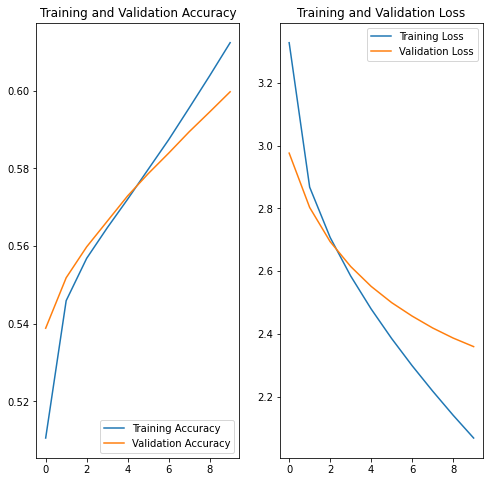

✅


In [29]:
import matplotlib.pyplot as plt

acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

### 5-2 평가하기
- 시작 문장을 입력하면 입력된 값을 바탕으로 모델이 작문을 하는 함수 작성

In [30]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <end>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [38]:
generate_text(model, tokenizer, init_sentence="<start> i", max_len=20)

'<start> i m the one gon hold you down <end> '

In [39]:
ai_keyword = ["i", "love"]

In [40]:
for i in ai_keyword:
    print(generate_text(model, tokenizer, init_sentence=i, max_len=50))

i m so much , i m not a little bit <end> 
love is , baby , baby , baby , baby , baby , baby <end> 


Q4. 모델이 생성한 가사 한 줄을 제출하세요.

평가문항|상세기준
---|---
1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?|텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?
2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?|특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
3. 텍스트 생성모델이 안정적으로 학습되었는가?|텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

1) 기존에 사용했던 CNN + Dense와 어떤차이가있을까
가위바위보 했던 
LSTM
어텐션


2) pad를 왜 사용해야할까

토크나이저

패딩

쀍쀍 데이터

3)4-4처럼 학습하면 결과물로 어떤 결과가 나온건지에 대해

